<a href="https://colab.research.google.com/github/MALINI-05/Buildings-Segmentation/blob/main/Copy_of_BUILDING_DATASET_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load images and masks from a directory
def load_dataset(images_path, masks_path, img_size=(256, 256)):
    images = []
    masks = []

    image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.tiff', '.png'))])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.endswith(('.png', '.tiff'))])

    for img_file, mask_file in zip(image_files, mask_files):
        # Load the image and mask
        img = cv2.imread(os.path.join(images_path, img_file))
        mask = cv2.imread(os.path.join(masks_path, mask_file), cv2.IMREAD_GRAYSCALE)

        # Resize to a consistent shape
        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)

        # Normalize the image
        img = img / 255.0
        mask = mask / 255.0

        # Append to lists
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Define the dataset directories in png format
train_images_path = '/content/drive/MyDrive/archive/png/train'
train_masks_path = '/content/drive/MyDrive/archive/png/train_labels'
valid_images_path = '/content/drive/MyDrive/archive/png/val'
valid_masks_path = '/content/drive/MyDrive/archive/png/val_labels'
test_images_path = '/content/drive/MyDrive/archive/png/test'
test_masks_path = '/content/drive/MyDrive/archive/png/test_labels'


# Load the datasets
X_train, y_train = load_dataset(train_images_path, train_masks_path)
X_valid, y_valid = load_dataset(valid_images_path, valid_masks_path)
X_test, y_test = load_dataset(test_images_path, test_masks_path)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_valid.shape}, {y_valid.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (132, 256, 256, 3), (132, 256, 256)
Validation set: (4, 256, 256, 3), (4, 256, 256)
Test set: (10, 256, 256, 3), (10, 256, 256)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Down-sampling (encoding)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Up-sampling (decoding)
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([up1, conv2])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([up2, conv1])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv5)  # Keep spatial dimensions

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Build the model
model = unet_model(input_size=(256, 256, 3))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 256)  │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 384)  │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 256, 128)  │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 192)  │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │        110,656 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.6478 - loss: 0.6337 - val_accuracy: 0.8738 - val_loss: 0.5589
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 742ms/step - accuracy: 0.8462 - loss: 0.5189 - val_accuracy: 0.8738 - val_loss: 0.5788
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 750ms/step - accuracy: 0.8420 - loss: 0.5704 - val_accuracy: 0.8738 - val_loss: 0.4771
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 741ms/step - accuracy: 0.8426 - loss: 0.4751 - val_accuracy: 0.8738 - val_loss: 0.3990
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 742ms/step - accuracy: 0.8442 - loss: 0.4249 - val_accuracy: 0.8738 - val_loss: 0.3819
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 741ms/step - accuracy: 0.8425 - loss: 0.4182 - val_accuracy: 0.8738 - val_loss: 0.3930
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 743ms/step - accuracy: 0.8444 - loss: 0.4140 - val_accuracy: 0.8738 - val_loss: 0.3768
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 751ms/step - accuracy: 0.8435 - loss: 0.4047 - val_accuracy: 0.8738 - val_loss:

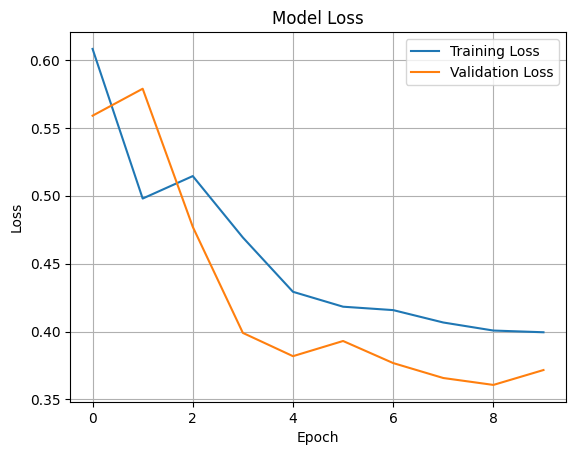

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

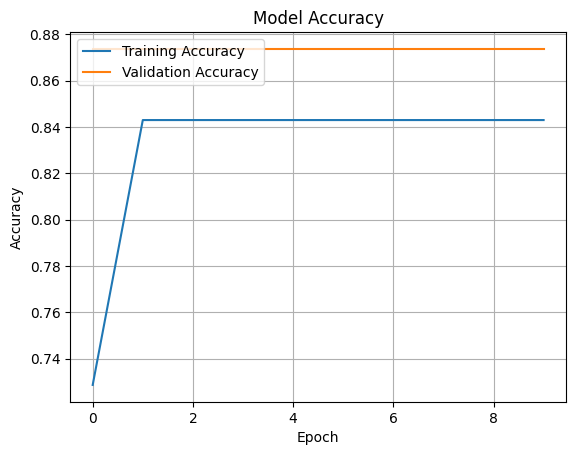

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Directory to save checkpoints
checkpoint_dir = 'checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras'), # Changed extension to .keras
    monitor='val_loss',  # Monitor validation loss
    save_best_only=False,  # Set to True if you want to save only the best model
    save_weights_only=False,  # Save the full model (set to True for saving only weights)
    mode='min',  # Save when val_loss is minimized
    verbose=1  # Verbose output to track when the model is being saved
)

# Train the model with checkpoint callback
history = model.fit(
    X_train, y_train, # Make sure these variable names match how you defined them
    epochs=1500,  # Number of epochs
    batch_size=16,  # Batch size
    validation_data=(X_valid, y_valid),  # Validation data # Make sure these variable names match how you defined them
    callbacks=[checkpoint_callback]  # Add checkpoint callback here
)

Streaming output truncated to the last 5000 lines.
Epoch 251/1500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8463 - loss: 0.3516
Epoch 251: saving model to checkpoints/model_epoch_251_val_loss_0.3851.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.8468 - loss: 0.3508 - val_accuracy: 0.8704 - val_loss: 0.3851
Epoch 252/1500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8488 - loss: 0.3487
Epoch 252: saving model to checkpoints/model_epoch_252_val_loss_0.3829.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step - accuracy: 0.8491 - loss: 0.3480 - val_accuracy: 0.8708 - val_loss: 0.3829
Epoch 253/1500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8481 - loss: 0.3464
Epoch 253: saving model to checkpoints/model_epoch_253_val_loss_0.3886.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 0.8486 - loss: 0.3457 - val_accuracy: 0.8683 - val_loss: 0.3886
Epoch 254/1500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8515 - loss: 0.3407
Epoch 254: saving mod

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.8381 - loss: 0.8785
Test Accuracy: 0.8381195068359375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


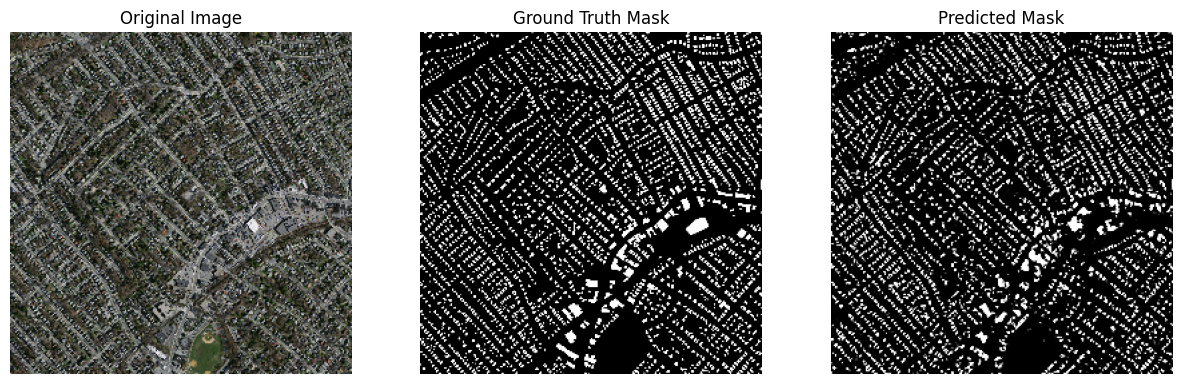

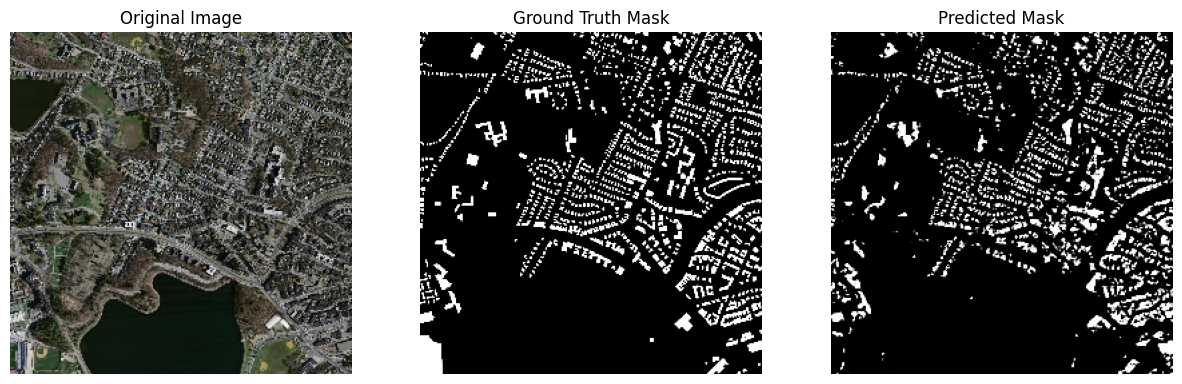

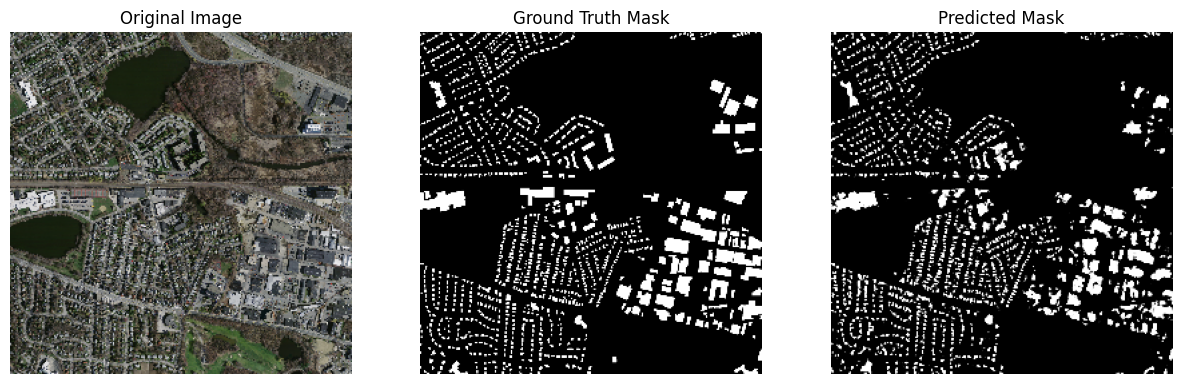

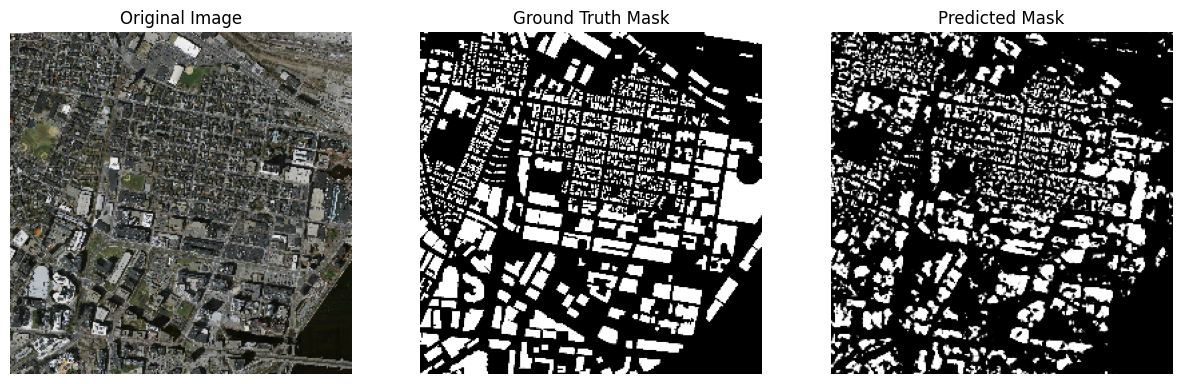

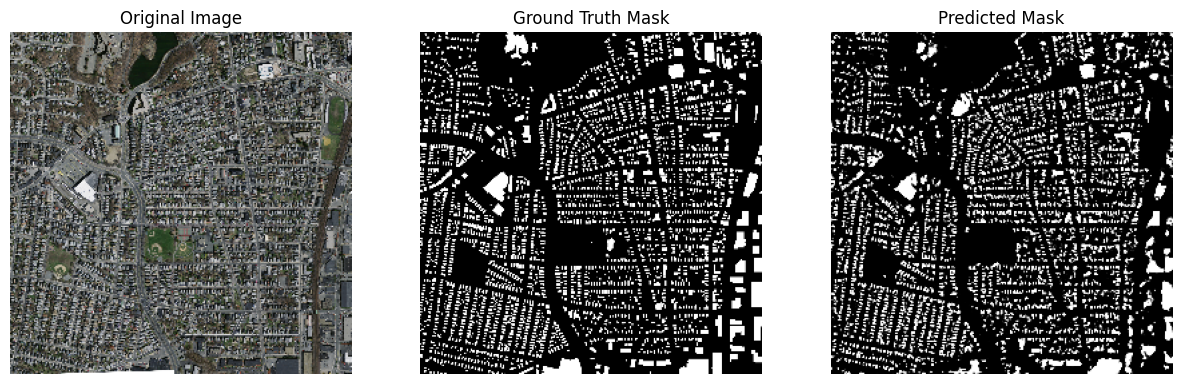

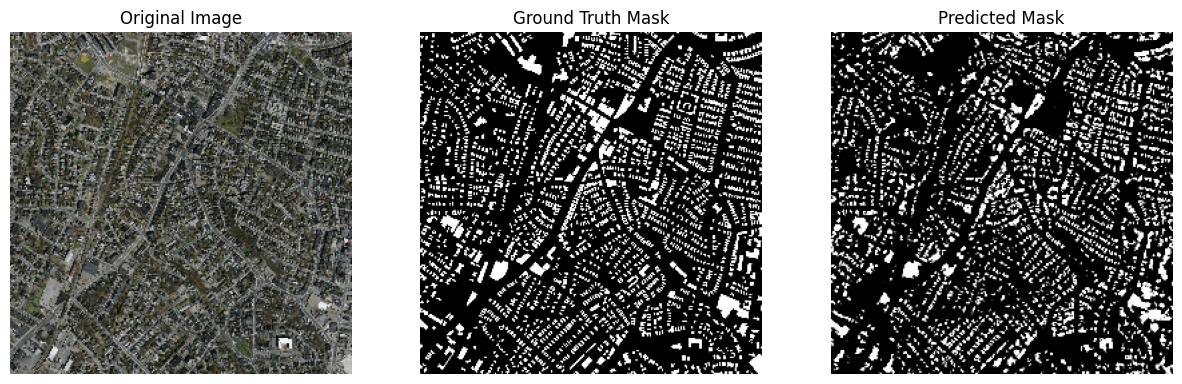

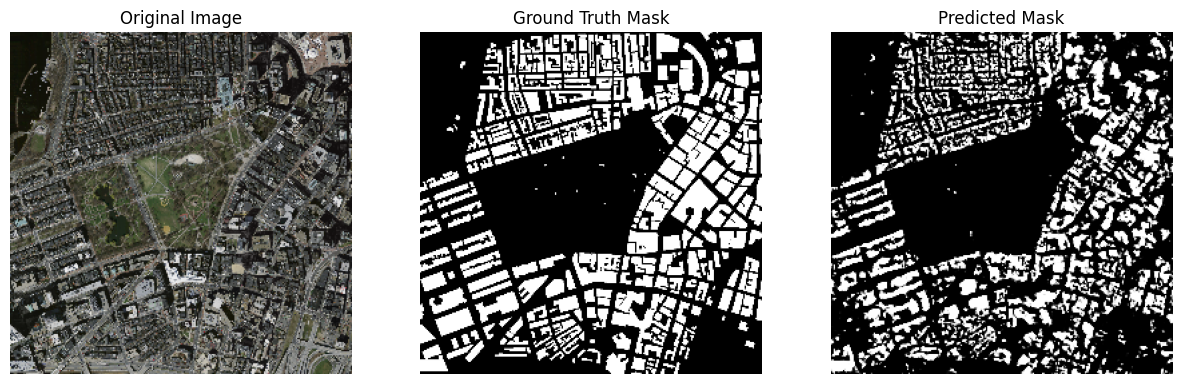

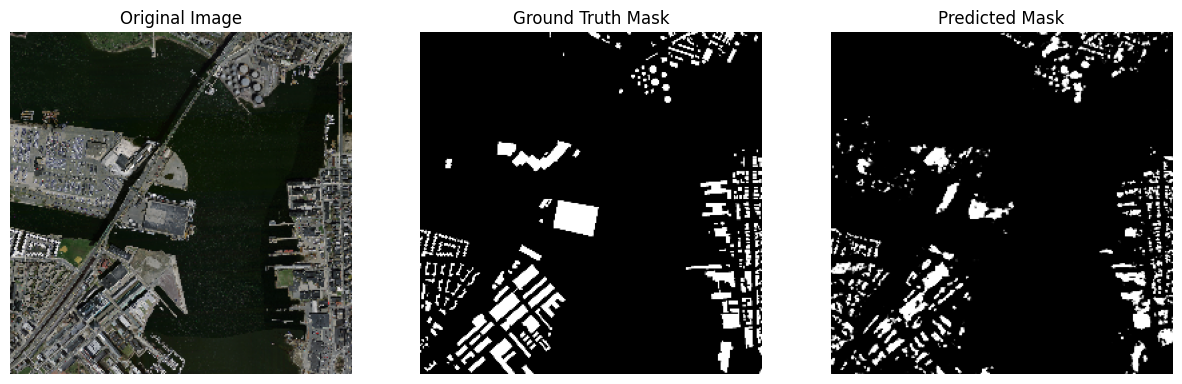

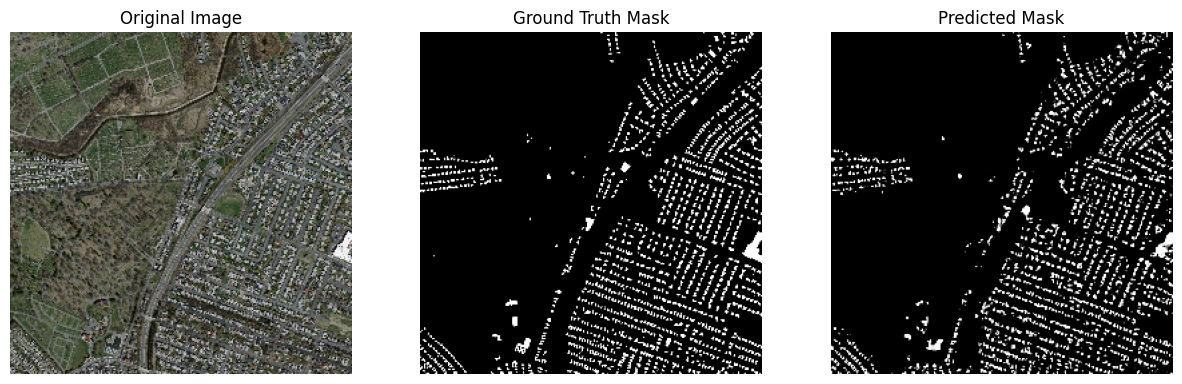

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Predict on test images
predictions = model.predict(X_test)

# Visualize some predictions
def display_predictions(images, masks, predictions, num_samples=9):
    for i in range(num_samples):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        #convert the image to uint8 before color conversion
        img_uint8 = (images[i] * 255).astype(np.uint8)
        ax[0].imshow(cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(masks[i], cmap='gray')
        ax[1].set_title('Ground Truth Mask')
        ax[1].axis('off')

        ax[2].imshow(predictions[i].squeeze(), cmap='gray')
        ax[2].set_title('Predicted Mask')
        ax[2].axis('off')

        plt.show()

# Display predictions
display_predictions(X_test, y_test, predictions)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/my_model (2).keras')

# Or load from SavedModel format
model = load_model('/content/drive/MyDrive/my_model (2).keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMG-20240904-WA0005.jpg to IMG-20240904-WA0005 (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


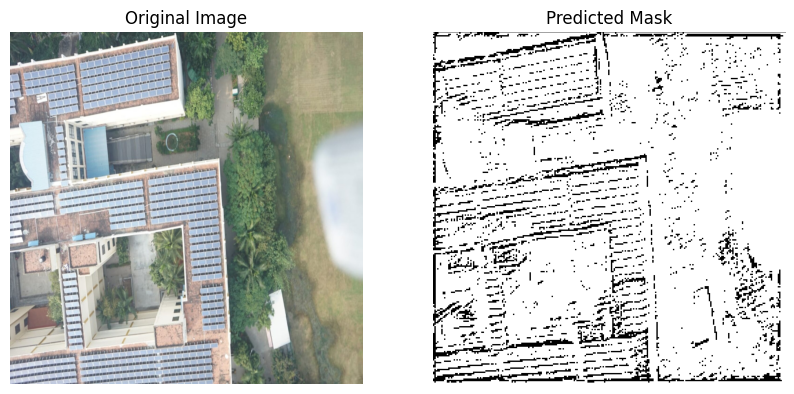

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/my_model (2).keras")

# Function to preprocess input image
def preprocess_image(image_path, img_size=(256, 256)):
    # Load the image
    img = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not load image from {image_path}. Please check the file path.")
        return None, None

    # Resize to match the input size of the model
    img_resized = cv2.resize(img, img_size)

    # Normalize the image
    img_normalized = img_resized / 255.0

    # Add batch dimension (required for model prediction)
    img_batch = np.expand_dims(img_normalized, axis=0)

    return img_batch, img

# Function to post-process and display the prediction
def display_prediction(image_path):
    # Preprocess the image
    img_batch, original_img = preprocess_image(image_path)

    # Check if image loading was successful
    if img_batch is None:
        return  # Exit the function if image loading failed

    # Perform prediction
    pred_mask = model.predict(img_batch)

    # Remove batch dimension and squeeze to remove channel dimension
    pred_mask = np.squeeze(pred_mask, axis=0)

    # Threshold the mask (0.5 threshold for binary segmentation)
    pred_mask[pred_mask >= 0.5] = 1
    pred_mask[pred_mask < 0.5] = 0

    # Visualize the results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    # Predicted Mask
    ax[1].imshow(pred_mask, cmap='gray')
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

    plt.show()

# Example usage in Google Colab
image_path = '/content/IMG-20240904-WA0005.jpg'
 # After uploading
display_prediction(image_path)

In [ ]:
from google.colab import files
import zipfile
import os
from PIL import Image

# Step 3: Create a new directory to save converted images
output_folder_path = '/content/drive/MyDrive/Main Testing/!'
os.makedirs(output_folder_path, exist_ok=True)

# Step 4: Convert and save images
image_folder_path = '/content/images_folder'

for filename in os.listdir(image_folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust file types as needed
        image_path = os.path.join(image_folder_path, filename)

        # Open the image
        with Image.open(image_path) as img:
            # Convert and save the image (e.g., to JPEG format)
            converted_path = os.path.join(output_folder_path, f"{os.path.splitext(filename)[0]}.jpg")
            img.convert('RGB').save(converted_path, 'JPEG')

print(f"Converted images saved in: {output_folder_path}")
